# Surrogate Outcomes

This notebook demos eponymous algorithm from [Surrogate Outcomes and Transportability](https://arxiv.org/abs/1806.07172) (Tikka and Karvanen, 2018).

In [1]:
from matplotlib_inline.backend_inline import set_matplotlib_formats

from y0.algorithm.identify import identify_outcomes
from y0.algorithm.transport import identify_target_outcomes
from y0.dsl import Pi1, Pi2, Variable
from y0.examples import cancer_example
from y0.graph import NxMixedGraph
from y0.mutate.contract import recursive_contract

set_matplotlib_formats("svg")

/Users/cthoyt/dev/y0/src/y0/examples/__init__.py:1173: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  asia_df = pd.read_csv(ASIA_PATH).replace({"yes": 1, "no": -1})


## Smoking and Cancer

The first scenario we will explore is about the relationship between smoking ($S$), accumulation of tar in the lungs ($T$), and cancer ($C$). 

In [2]:
from y0.dsl import C as Cancer
from y0.dsl import S as Smoking
from y0.dsl import T as Tar

We construct a causal model where we know the following three statements that translate into directed edges in our acyclic directed mixed graph:

1. Smoking causes an accumulation of tar in the lungs
2. Accumulation of tar in the lungs increases risk of cancer
3. Smoking itself also increases the risk of cancer

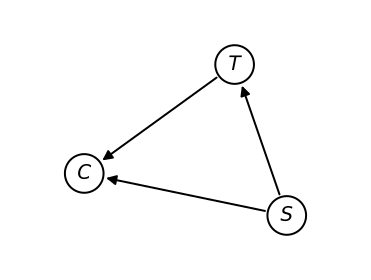

In [3]:
cancer_graph = NxMixedGraph.from_edges(directed=[(Smoking, Tar), (Tar, Cancer), (Smoking, Cancer)])
cancer_graph.draw()

It's possible to identify the effect of smoking on cancer in this constrained scenario. This can be translated to using the `identify_outcomes`, i.e. the [ID algorithm](https://dl.acm.org/doi/10.5555/1597348.1597382).

In [4]:
identify_outcomes(cancer_graph, treatments={Smoking}, outcomes={Cancer})

Sum[T](P(C | S, T) * P(T | S))

### A more realistic scenario

However, this first model is not a very accurate representation of reality. Therefore, we add a _bidirected_ edge between smoking and the accumulation of tar in the lungs because there might be an unknown confounder. In the scenario we pose below, this is an observational study is conducted where we don't know who smokes tar-free cigarettes and who smokes regular cigarettes.

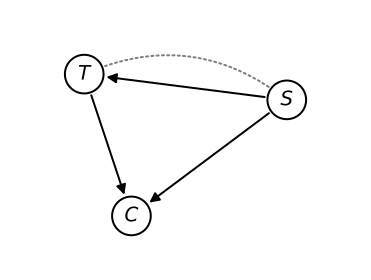

In [5]:
# Note that this is pre-loaded in y0
cancer_graph = cancer_example.graph

cancer_graph.draw()

We're now in a scenario where it's not possible to identify the effect of smoking on cancer.

In [6]:
identify_outcomes(cancer_example.graph, treatments={Smoking}, outcomes={Cancer}) is None

True

If we had some interventional data that measures cancer, we can address this by doing some regular statistics, we don't need this causal inference framework. However, we don't have that data.

### Using data to address the more realistic scenario

But, we're not out of luck, because such a graph can be identified if a combination of interventional and observational data are available.

Suppose Pall Mall has a new cigarette that has no tar in it!  They conduct a clinical trial ($\pi_1$; this is interventional data) where they randomly assign some volunteers to smoke their new cigarette, and the other volunteers receive regular cigarettes. As an outcome, they measure tar buildup in the lungs. The trial is stopped before any of the volunteers get cancer, so we're not able to measure this variable.

This trial does not have enough information to estimate the causal effect of smoking on cancer $P^{\pi_1}(C | \text{do}(S))$ from the measurements of $P^{\pi_1}(T | \text{do}(S)$. E.g., you measure the correlate, but not the outcome.

In [7]:
# we simulate some interventional data
interventional_data = cancer_example.generate_data(1000, treatments={Tar: 1})

 At the same time, we have observational data ($\pi^\ast$) over many years that show the correlation of smoking on cancer, but we don't know who chose the Pall Mall "no tar" cigarettes vs the tar-filled cigarettes.  This observational data does not have enough information to estimate $P^{\pi^\ast}(C | \text{do}(S)$ from the measurements of $P^{\pi^\ast}(S, C, T)$.

In [8]:
# we simulate some observational data
observational_data = cancer_example.generate_data(1000)

Neither dataset is sufficient to estimate the causal effect of smoking on cancer, but perhaps by combining the two, we can identify the query using the [surrogate outcomes and transportability algorithm](https://arxiv.org/abs/1806.07172).

In [9]:
recursive_contract(
    identify_target_outcomes(
        cancer_graph,
        target_outcomes={Cancer},  # target => observational data
        target_interventions={Smoking},
        surrogate_outcomes={Pi1: {Tar}},  # surrogate => interventional data
        surrogate_interventions={Pi1: {Smoking}},
    )
)

Sum[T](PP[pi*](C | S, T) * PP[π1][S](T))

We can interpret this result as taking the observational data ($\pi^\ast$) such that the conditional $P(Cancer| Smoking, Tar)$ is stratified by Tar, and reweighting the percentage of people who have tar in their lungs by the percentage of people who had tar in their lungs in the clinical trial ($\pi_1$).  The summation over Tar means that the final estimate will only have Smoking and Cancer in it.  If you didn't do the reweighting, you would only recover the probability of cancer given smoking.

Note that the surrogate outcomes algorithm implicitly assumes that observational data from the target population is always available.

## Relation between going to Class and Getting a Job

Suppose we want to find out if going to class during college has an effect on getting a job after graduation. We have the observational data that shows relationships between going to class, test scores, gpa, and jobs after graduation but the observational data is not enough to estimate $P^{\pi^\ast}(Job | \text{do}(Class)$ $P^{\pi^\ast}(Class, Scores, GPA, Job)$

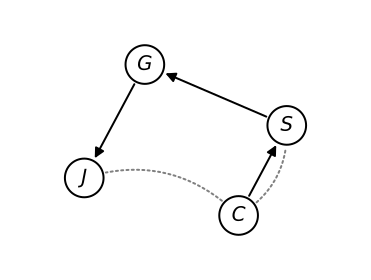

In [10]:
Class, Scores, GPA, Job = (
    Variable("C"),
    Variable("S"),
    Variable("G"),
    Variable("J"),
)

graph = NxMixedGraph.from_edges(
    directed=[(Class, Scores), (Scores, GPA), (GPA, Job)],
    undirected=[(Scores, Class), (Job, Class)],
)
graph.draw()

Assume that an experiment tested how students performed on tests by assigning some students to attend class, while other to not attend, this gives us $P^{\pi_2}(Scores | \text{do}(Class)$.  Another experiment was performed to test the relationship between getting a job and GPA where similar students with randomized GPA applied for jobs giving $P^{\pi_2}(Job | \text{do}(GPA)$. 

In [11]:
identify_outcomes(graph, treatments={Class}, outcomes={Job}) is None

True

In [12]:
identify_target_outcomes(
    graph=graph,
    target_interventions={Class},
    target_outcomes={Job},
    surrogate_interventions={Pi1: {Class}, Pi2: {GPA}},
    surrogate_outcomes={Pi1: {Scores}, Pi2: {Job}},
)

Sum[G, S](PP[π1][C](S) * PP[π2][G](J) * ((PP[pi*](C, G, S) / PP[pi*](C, S))))